# Visualtion and dealing with missing values

In [1]:
from plot_lib import plot_data, plot_model, set_default

In [2]:
set_default()

In [3]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
# load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
label = train.iloc[:,-1]

# train_labels = train.pop('SalePrice') # separate labels from train dataset
data = pd.concat([train, test], keys=['train', 'test'],axis=0).drop('SalePrice',axis=1)
# print(data.columns) # check column decorations
print('rows:', data.shape[0], ', columns:', data.shape[1]) # count rows of total dataset
print('rows in train dataset:', train.shape[0])
print('rows in test dataset:', test.shape[0])

rows: 2919 , columns: 80
rows in train dataset: 1460
rows in test dataset: 1459


It seems this is a huge dataset and we should know what all columns we have, to understand what to keep and what to drop with the first glance of our dataset.

In [6]:
# Checking Categorical Data
train.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [7]:
# Checking Numerical Data
train.select_dtypes(include=['int64','float64']).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

There are 79 columns in our dataset. Do you think they all are important? To understand that whether we should keep a certain column or not, we need to answer quick questions about each of them. For example:

1.Do we think about this variable when we are buying a house? (e.g. When we think about the house of our dreams, do we care about its 'Masonry veneer type'?).

2.If so, how important would this variable be? (e.g. What is the impact of having 'Excellent' material on the exterior instead of 'Poor'? And of having 'Excellent' instead of 'Good'?).

3.Is this information already described in any other variable? (e.g. If 'LandContour' gives the flatness of the property, do we really need to know the 'LandSlope'?).

Going through all the parameters, we think, two 'building' variables ('OverallQual' and 'YearBuilt') and two 'space' variables ('TotalBsmtSF' and 'GrLivArea') are few of the most important variables in deciding the prices of the house.



## Analyzing 'Sale Price'
Our main objective is to calculate the SalePrice. Before we start exploring the data, let's understand the basic statistical features of our dependent variable.


In [8]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Now let's try to figure out the normality of our 'SalePrice'.

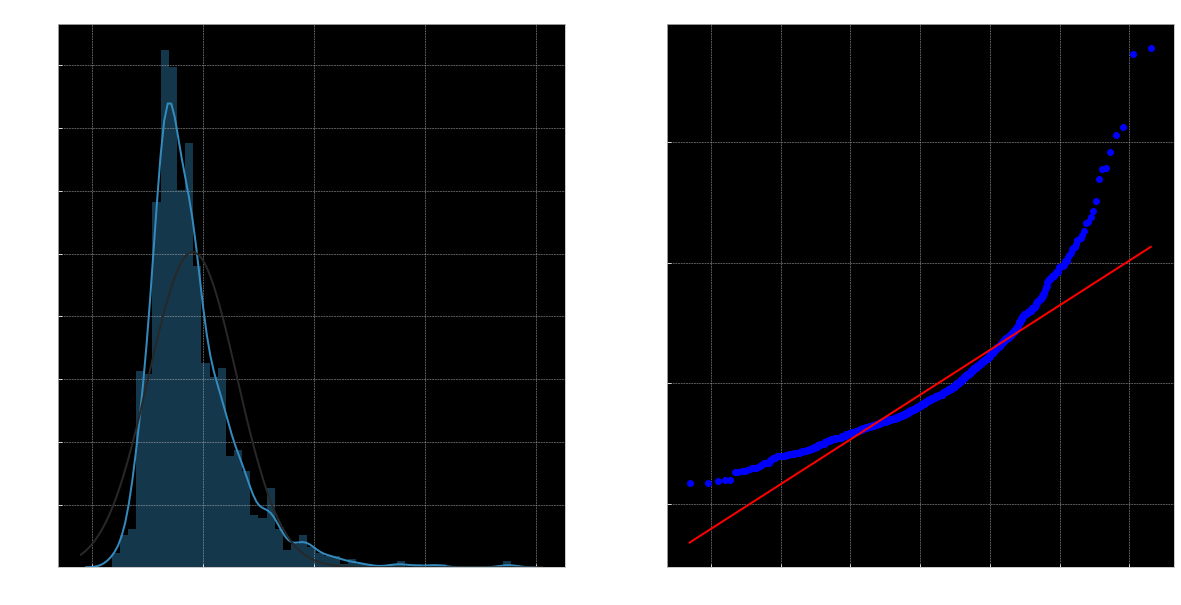

Skewness: 1.882876
Kurtosis: 6.536282


In [9]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.title("Sale Prices Dist")
sns.distplot(train.SalePrice, fit=stats.norm)
plt.subplot(1, 2, 2)
stats.probplot(train.SalePrice, plot=plt)
plt.show()
print("Skewness: %f" % train.SalePrice.skew())
print("Kurtosis: %f" % train.SalePrice.kurt())

Now this is interesting, we have our dependent variable right/poitive skewed and has a peak value too between range 100,000 and 200,000. and does not follow the diagonal line.

But everything's not lost. A simple data transformation can solve the problem. I learnt it in my data models and decision making curriculum that in case of positive skewness, log transformations usually works well.

what other transformations we can use ?

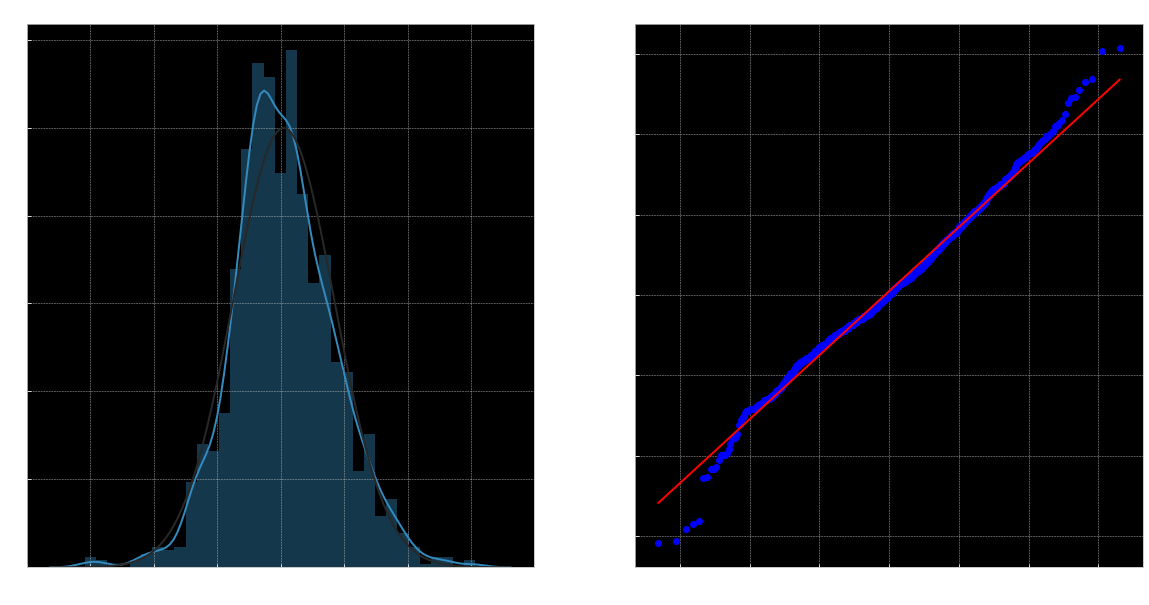

Skewness: 0.121335
Kurtosis: 0.809532


In [10]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.title("Sale Prices Dist")
sns.distplot(np.log(train.SalePrice), fit=stats.norm)
plt.subplot(1, 2, 2)
stats.probplot(np.log(train.SalePrice), plot=plt)
plt.show()
print("Skewness: %f" % np.log(train.SalePrice).skew())
print("Kurtosis: %f" % np.log(train.SalePrice).kurt())

Definitely 'SalePrice' is influenced by the other parameters. Let's start exploring our relation with the four parameters we listed above. We will use seaborn to visualize these relations because a picture always describe the best scenario to human eye.

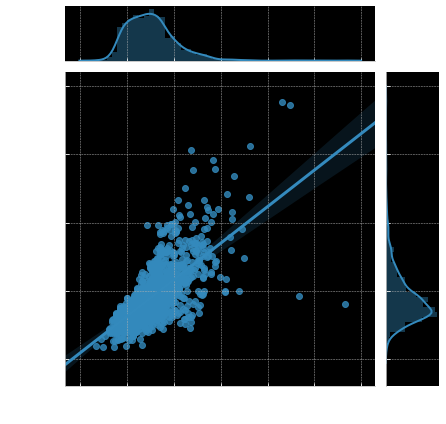

In [11]:
sns.jointplot(x='GrLivArea'  ,y='SalePrice',data=train,kind='reg')

It makes sense that people would pay for the more living area. What doesn't make sense is the two datapoints in the bottom-right of the plot.

We need to take care of this! What we will do is remove these outliers manually.

In [12]:
# # Removing outliers manually (Two points in the bottom right)
# train = train.drop(train[(train['GrLivArea']>4000) 
#                          & (train['SalePrice']<200000)].index).reset_index(drop=True)

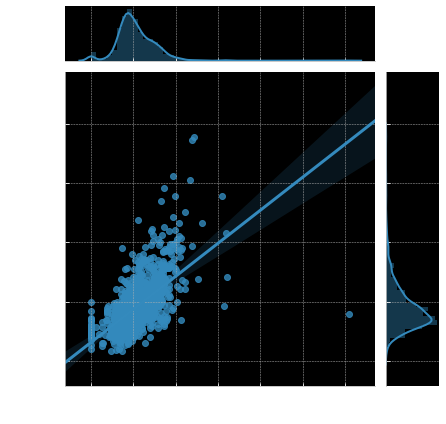

In [13]:
sns.jointplot(x='TotalBsmtSF',y='SalePrice',data=train,kind='reg')

And as per our previous calculations, the scatter plots here shows that 'GrLivArea' and 'TotalBsmtSF' have almost linear relationship with our dependent variable 'SalePrice' and have been playing very major role in deciding our house prices from a long time.

Ok. Now let's talk about 'OverallQual' column. Though it is calculated internally, but definitely it has a strong relation with our 'SalePrice'. Let's make a boxplot between them to understand their bonding.

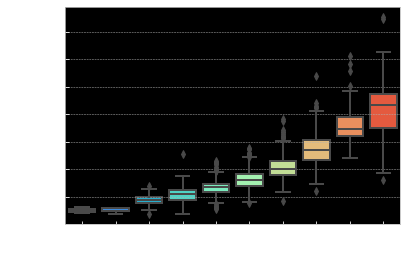

In [14]:
sns.boxplot(x="OverallQual", y="SalePrice", data=train,palette='rainbow')

People pay more for better quality? Nothing new here and our "SalePrice" increases with "OverallQual".

What about the "YearBuilt"? Definitely we have a tendency to spend more in the houses which our constructed recently. Let's check if our dataset is behaving in the same patter or not. A boxplot would be best again to show this relation.

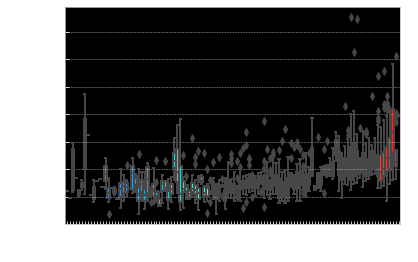

In [15]:
sns.boxplot(x="YearBuilt", y="SalePrice", data=train,palette='rainbow')

And we can see that our dataset behaves as we thought, "SalePrice" increases for the properties recently built.

But do you think are these four features enough to build our model for prediction of "SalePrice". We need to make sure that we are not missing out on important things and we select the right features to define our solution. Let's do a more objective analysis by building correlation matrix(heatmap matrix).

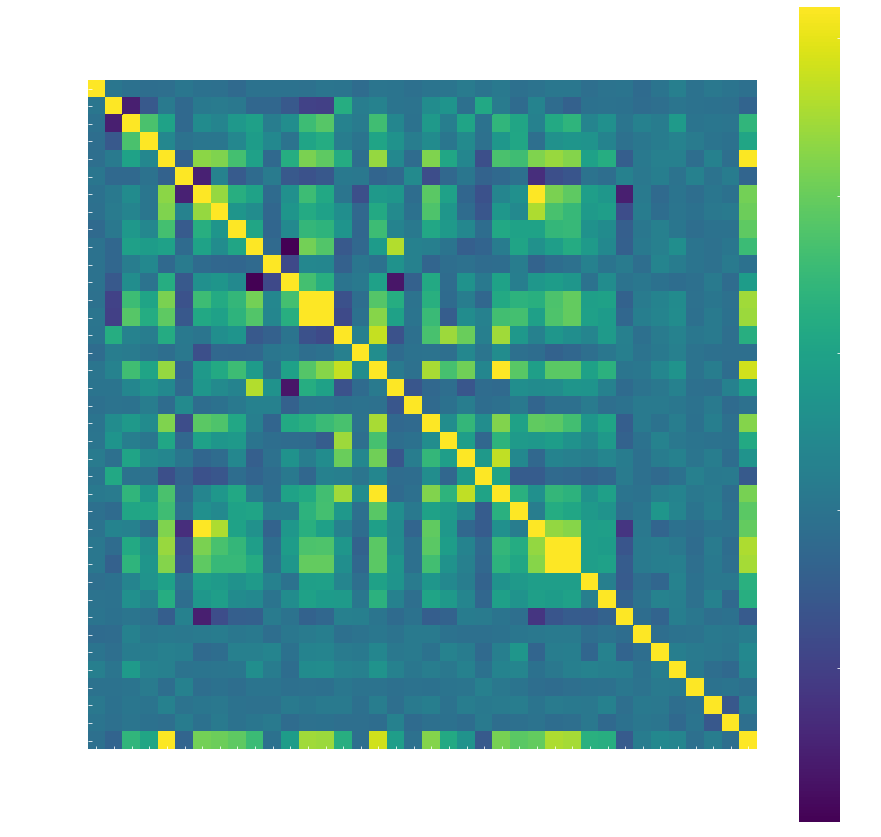

In [16]:
corrmat= train.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corrmat, vmax=.8, square=True,cmap='viridis',linecolor="white");
# vmax=.8, linewidths=0.01,square=True,annot=True,cmap='viridis',linecolor="white"

This is too huge. We need to narrow it down. Let's make a zoomed style heatmap for our 'SalePrice' by picking up the 10 variable with which our 'SalePrice' has the strongest correlation.

In [17]:
set_default()

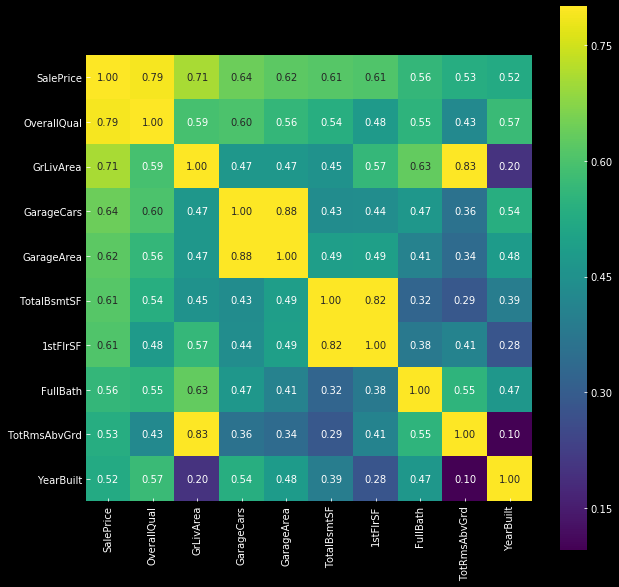

In [18]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
# sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True,  vmax=.8,annot=True, square=True, fmt='.2f', annot_kws={'size': 10},\
            yticklabels=cols.values, xticklabels=cols.values,cmap='viridis',linecolor="white")

In [19]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,SalePrice
1,OverallQual
2,GrLivArea
3,GarageCars
4,GarageArea
5,TotalBsmtSF
6,1stFlrSF
7,FullBath
8,TotRmsAbvGrd
9,YearBuilt


As we saw above there are few feature which shows high multicollinearity from heatmap. Lets focus on yellow squares on diagonal line and few on the sides.

SalePrice and OverallQual

GarageArea and GarageCars

TotalBsmtSF and 1stFlrSF

GrLiveArea and TotRmsAbvGrd

YearBulit and GarageYrBlt

We have to create a single feature from them before we use them as predictors.

These are the variables most correlated with 'SalePrice'.

1.'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'. Already checked!

2.'GarageCars' and 'GarageArea' are also strongly correlated variables. However,the number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers.Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).

3.'TotalBsmtSF' and '1stFloor' also seem to be twin brothers. We can keep 'TotalBsmtSF' just to say that our first guess was right.

4'FullBath'

5.'TotRmsAbvGrd' and 'GrLivArea', twin brothers again.

'YearBuilt'... It seems that 'YearBuilt' is slightly correlated with 'SalePrice'.

Let's proceed to the scatter plots.

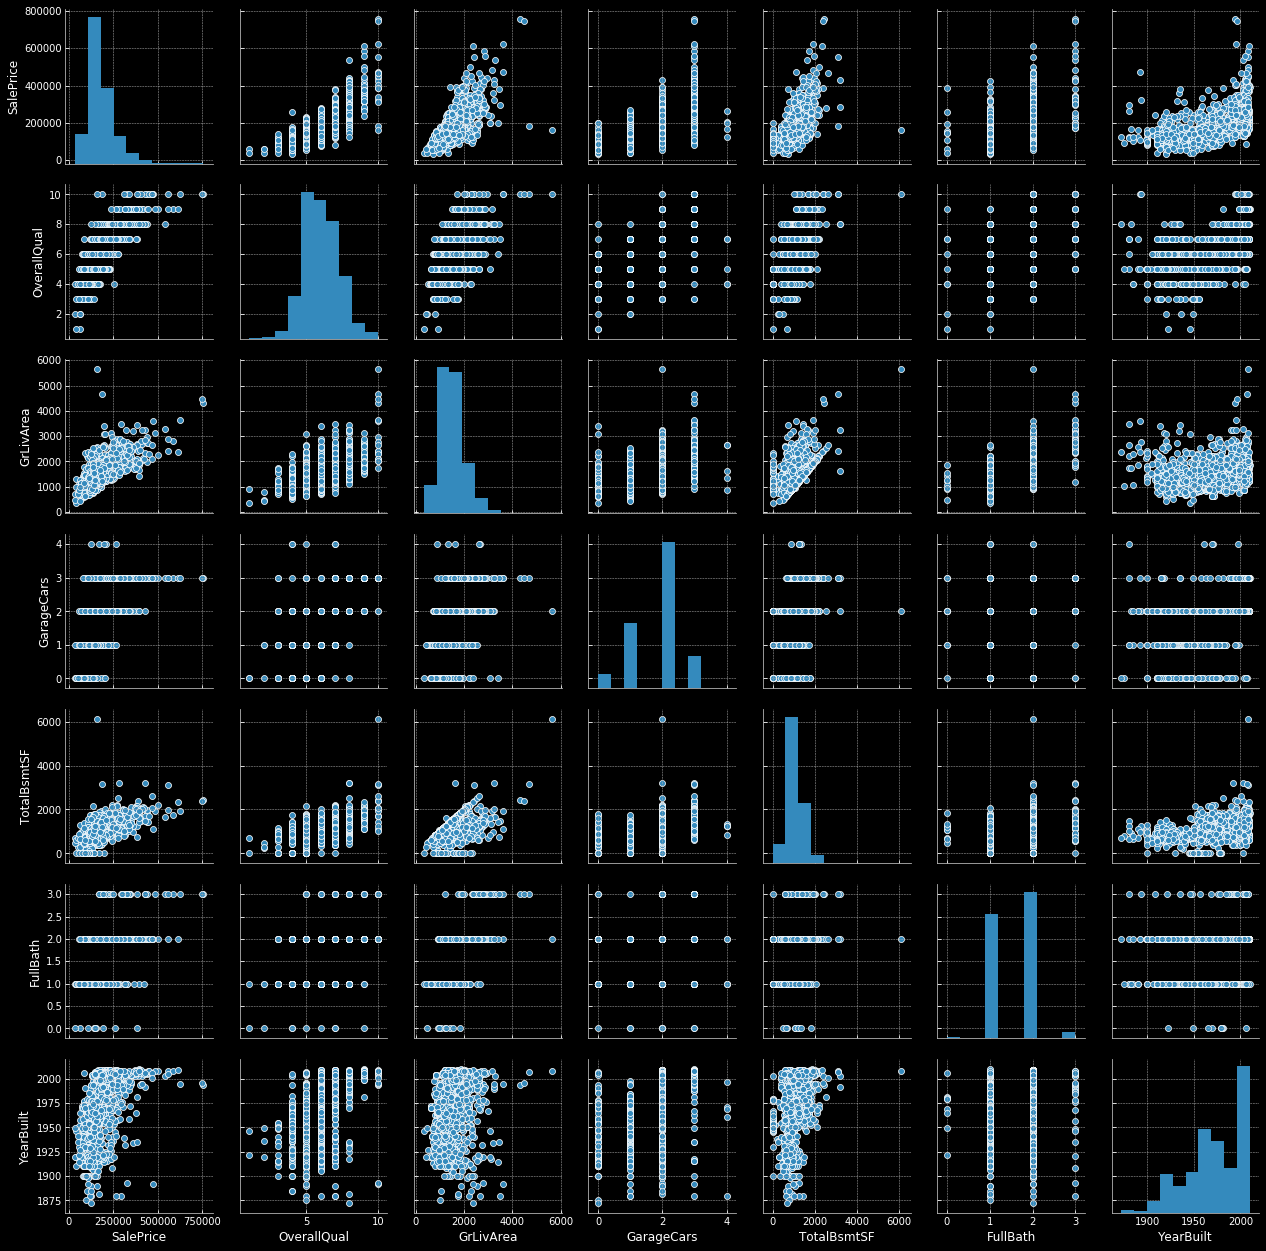

In [20]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols])

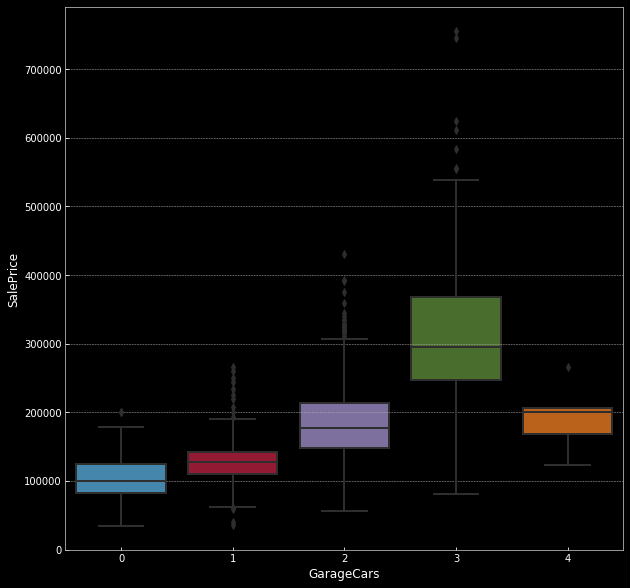

In [21]:
# Garage Area vs Sale Price
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

4-car garages result in less Sale Price? That doesn't make much sense. Let's remove those outliers.

In [22]:
# # Removing outliers manually (More than 4-cars, less than $300k)
# train = train.drop(train[(train['GarageCars']>3) 
#                          & (train['SalePrice']<300000)].index).reset_index(drop=True)

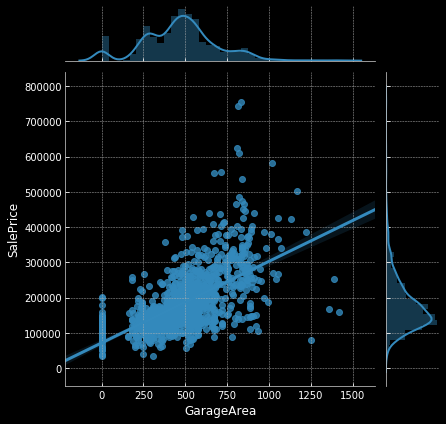

In [23]:
# Garage Area vs Sale Price
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')

Again with the bottom two data-points. Let's remove those outliers.

In [24]:
# # Removing outliers manually (More than 1000 sqft, less than $300k)
# train = train.drop(train[(train['GarageArea']>1000) 
#                          & (train['SalePrice']<300000)].index).reset_index(drop=True)

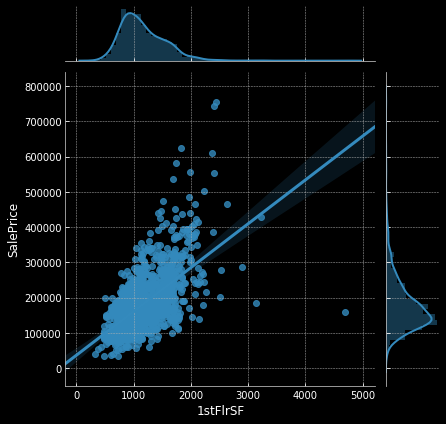

In [25]:
# First Floor Area vs Sale Price
sns.jointplot(x=train['1stFlrSF'], y=train['SalePrice'], kind='reg')

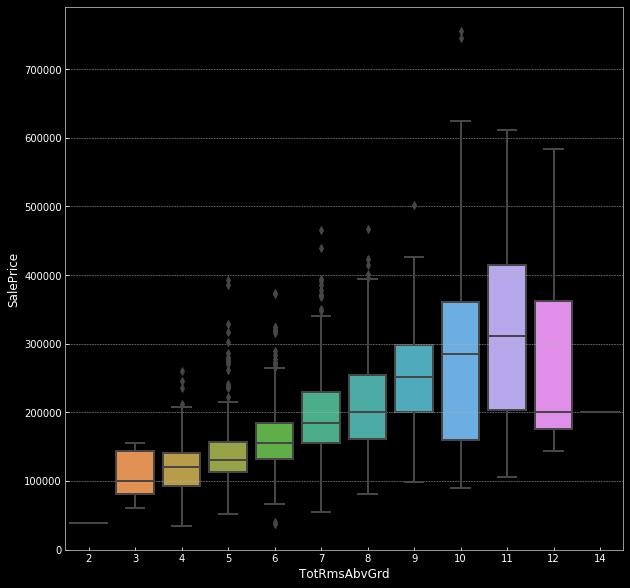

In [26]:
# Total Rooms vs Sale Price
sns.boxplot(x=train['TotRmsAbvGrd'], y=train['SalePrice'])

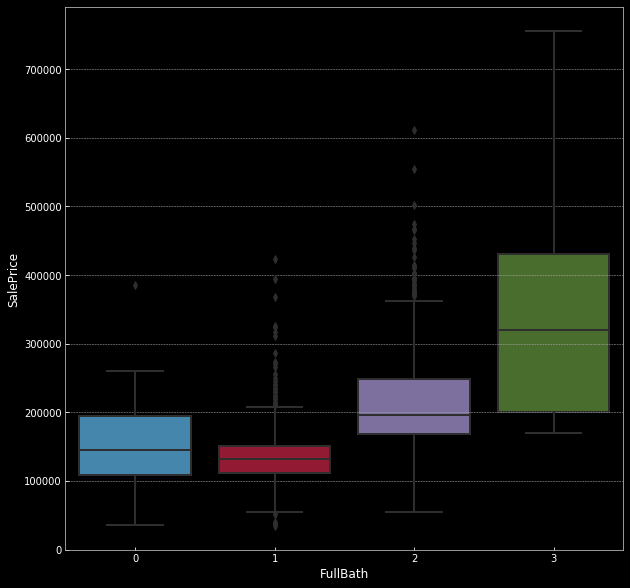

In [27]:
# Full Bath vs Sale Price
sns.boxplot(x=train['FullBath'], y=train['SalePrice'])

And this gives us the same picture again. Now let's move ahead and understand what to do with our missing data.

## Missing Data
Now, it is important to understand how much missing data we have and how we can fill it, so that it does not create a problem in our modelling.


In [28]:
nans = pd.concat([train.isnull().sum(),\
                  (train.isnull().sum() / train.shape[0])*100,\
                  test.isnull().sum(), \
                  (test.isnull().sum() / test.shape[0])*100],\
                 axis=1, keys=['Train', 'Percentage', 'Test', 'Percentage'])
print(nans[nans.sum(axis=1) > 0])

              Train  Percentage    Test  Percentage
Alley          1369   93.767123  1352.0   92.666210
BsmtCond         37    2.534247    45.0    3.084304
BsmtExposure     38    2.602740    44.0    3.015764
BsmtFinSF1        0    0.000000     1.0    0.068540
BsmtFinSF2        0    0.000000     1.0    0.068540
BsmtFinType1     37    2.534247    42.0    2.878684
BsmtFinType2     38    2.602740    42.0    2.878684
BsmtFullBath      0    0.000000     2.0    0.137080
BsmtHalfBath      0    0.000000     2.0    0.137080
BsmtQual         37    2.534247    44.0    3.015764
BsmtUnfSF         0    0.000000     1.0    0.068540
Electrical        1    0.068493     0.0    0.000000
Exterior1st       0    0.000000     1.0    0.068540
Exterior2nd       0    0.000000     1.0    0.068540
Fence          1179   80.753425  1169.0   80.123372
FireplaceQu     690   47.260274   730.0   50.034270
Functional        0    0.000000     2.0    0.137080
GarageArea        0    0.000000     1.0    0.068540
GarageCars  

In [29]:
missing_values = data.isnull().sum()
missing_values[missing_values>0].sort_values(ascending = False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageArea         1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
dtype: int64

### 1. Alley: Type of alley access to property
       
       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

In [30]:
data['Alley'] = data['Alley'].fillna('None')

### 2.BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

In [31]:
data['BsmtCond'] = data['BsmtCond'].fillna('None')

### 3.BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

In [32]:
data['BsmtExposure'] = data['BsmtExposure'].fillna('None')

### 4.BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

In [33]:
data['BsmtFinType1'] = data['BsmtFinType1'].fillna('None')

### 5.BsmtFinSF1: Type 1 finished square feet

In [34]:
data[data['BsmtFinSF1'].isna()]['BsmtFinType1']

test  660    None
Name: BsmtFinType1, dtype: object

In [35]:
data[data['BsmtFinType1']=='None']['BsmtFinSF1'].unique()

array([ 0., nan])

In [36]:
data['BsmtFinSF1'] = data['BsmtFinSF1'].fillna(0)

### 6.BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

In [37]:
data['BsmtFinType2'] = data['BsmtFinType2'].fillna('None')

### 7.BsmtFinSF2: Type 2 finished square feet

In [38]:
data[data['BsmtFinSF2'].isna()]['BsmtFinType2']

test  660    None
Name: BsmtFinType2, dtype: object

In [39]:
data[data['BsmtFinType2']=='None']['BsmtFinSF2'].unique()

array([  0., 479.,  nan])

In [40]:
data[data['BsmtFinType2']=='None']['BsmtFinSF2'].mode()

0    0.0
dtype: float64

In [41]:
data['BsmtFinSF2'] = data['BsmtFinSF2'].fillna(0)

### 8.BsmtUnfSF: Unfinished square feet of basement area


In [42]:
data[data['BsmtUnfSF']!=0]['BsmtUnfSF'].median()

520.0

In [43]:
data['BsmtUnfSF'] = data['BsmtUnfSF'].fillna(520)

### 9.TotalBsmtSF: Total square feet of basement area

In [44]:
data[data['TotalBsmtSF'].isna()]['BsmtUnfSF']

test  660    520.0
Name: BsmtUnfSF, dtype: float64

In [45]:
data['TotalBsmtSF'] = data['TotalBsmtSF'].fillna(520)

### 10.BsmtFullBath: Basement full bathrooms


In [46]:
data[data['BsmtFullBath'].isna()]['BsmtFinSF1']

test  660    0.0
      728    0.0
Name: BsmtFinSF1, dtype: float64

In [47]:
data['BsmtFullBath'] = data['BsmtFullBath'].fillna(0)

### 11.BsmtHalfBath: Basement half bathrooms


In [48]:
data[data['BsmtHalfBath'].isna()]['BsmtFinSF1']

test  660    0.0
      728    0.0
Name: BsmtFinSF1, dtype: float64

In [49]:
data['BsmtHalfBath'] = data['BsmtHalfBath'].fillna(0)

### 12.KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

In [50]:
data[data['KitchenQual'].isna()]['KitchenAbvGr']

test  95    1
Name: KitchenAbvGr, dtype: int64

In [51]:
data[data['KitchenAbvGr']==1]['KitchenQual'].mode()

0    TA
dtype: object

In [52]:
data['KitchenQual'] = data['KitchenQual'].fillna('TA')

### 13.Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

In [53]:
data['Functional'].mode()

0    Typ
dtype: object

In [54]:
data['Functional'] = data['Functional'].fillna('Typ')

### 14.FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

In [55]:
data['FireplaceQu'] = data['FireplaceQu'].fillna('None')

### 15.GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage

In [56]:
data['GarageType'] = data['GarageType'].fillna('None')

### 16.GarageYrBlt: Year garage was built

In [57]:
data['GarageYrBlt'].mode()

0    2005.0
dtype: float64

In [58]:
data[data['GarageYrBlt']==2005]['GarageYrBlt'].count()

142

In [59]:
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(2005)

### 17.Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

In [60]:
data['Electrical'].mode()

0    SBrkr
dtype: object

In [61]:
data['Electrical'] = data['Electrical'].fillna('SBrkr')

### 18.GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

In [62]:
data['GarageFinish'] = data['GarageFinish'].fillna('None')

### 19.GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

In [63]:
data['GarageQual'] = data['GarageQual'].fillna('None')

### 20.GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

In [64]:
data['GarageCond'] = data['GarageCond'].fillna('None')

### 21.PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

In [65]:
data['PoolQC'] = data['PoolQC'].fillna('None')

### 22.Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

In [66]:
data['Fence'] = data['Fence'].fillna('None')

### 23.MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

In [67]:
data['MiscFeature'] = data['MiscFeature'].fillna('None')

### 24.SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other

In [68]:
data[data['SaleType'].isna()]

,,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
test,1029,1176,0,0,None,3,1Fam,TA,Mn,190.0,873.0,...,NaN,0,Pave,6,1158.0,AllPub,0,1958,1998,2007


In [69]:
data[(data['MSSubClass']==20) & (data['MSZoning']=='RL') &
         (data['YearBuilt']<1960) & (data['YrSold']==2007)]['SaleType'].mode()

0    WD
dtype: object

In [70]:
data['SaleType'] = data['SaleType'].fillna('WD')

### 25.GarageCars: Size of garage in car capacity


In [71]:
data[data['GarageCars'].isna()]['GarageFinish']

test  1116    None
Name: GarageFinish, dtype: object

In [72]:
data['GarageCars'] = data['GarageCars'].fillna(0)

### 26.GarageArea: Size of garage in square feet

In [73]:
data[data['GarageArea'].isna()]['GarageFinish']

test  1116    None
Name: GarageFinish, dtype: object

In [74]:
data['GarageArea'] = data['GarageArea'].fillna(0)

### 27.MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

In [75]:
data['MSZoning'].mode()

0    RL
dtype: object

In [76]:
data['MSZoning'] = data['MSZoning'].fillna('RL')

### 28. Lot Frontage

In [77]:
data['LotFrontage'].isna().sum()

486

In [78]:
data['LotFrontage'].mode()

0    60.0
dtype: float64

In [79]:
data['LotFrontage'] = data['LotFrontage'].fillna(60)

### 29.Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only

In [80]:
data['Utilities'].mode()

0    AllPub
dtype: object

In [81]:
data['Utilities'] = data['Utilities'].fillna('AllPub')

### 30.Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

In [82]:
data['Exterior1st'].mode()

0    VinylSd
dtype: object

In [83]:
data['Exterior1st'] = data['Exterior1st'].fillna('VinylSd')

### 31.Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

In [84]:
data['Exterior2nd'].mode()

0    VinylSd
dtype: object

In [85]:
data['Exterior2nd'] = data['Exterior2nd'].fillna('VinylSd')

### 32.MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

In [86]:
data['MasVnrType'] = data['MasVnrType'].fillna('None')

### 33.MasVnrArea: Masonry veneer area in square feet

In [87]:
data['MasVnrArea'].median()

0.0

In [88]:
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)

### 34.BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

In [89]:
data['BsmtQual'] = data['BsmtQual'].fillna('None')

In [90]:
data.isna().sum()

1stFlrSF         0
2ndFlrSF         0
3SsnPorch        0
Alley            0
BedroomAbvGr     0
BldgType         0
BsmtCond         0
BsmtExposure     0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtFinType1     0
BsmtFinType2     0
BsmtFullBath     0
BsmtHalfBath     0
BsmtQual         0
BsmtUnfSF        0
CentralAir       0
Condition1       0
Condition2       0
Electrical       0
EnclosedPorch    0
ExterCond        0
ExterQual        0
Exterior1st      0
Exterior2nd      0
Fence            0
FireplaceQu      0
Fireplaces       0
Foundation       0
FullBath         0
                ..
LotFrontage      0
LotShape         0
LowQualFinSF     0
MSSubClass       0
MSZoning         0
MasVnrArea       0
MasVnrType       0
MiscFeature      0
MiscVal          0
MoSold           0
Neighborhood     0
OpenPorchSF      0
OverallCond      0
OverallQual      0
PavedDrive       0
PoolArea         0
PoolQC           0
RoofMatl         0
RoofStyle        0
SaleCondition    0
SaleType         0
ScreenPorch 

In [91]:
# Save
train = data.iloc[:1460,:]
test = data.iloc[1460:,:]

In [92]:
train.to_csv('train_cleaning.csv',index=False)
test.to_csv('test_cleaning.csv',index=False)
label.to_csv('label.csv',header=True,index=False)

In [93]:
train.shape, test.shape

((1460, 80), (1459, 80))